In [1]:
import h5py
import numpy as np
from scipy.io import netcdf
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
fpath_eddy = '/gscratch/jisao/mclaret/GL64/Juillet/'
f = h5py.File(fpath_eddy + 'eddy_tracks.mat')

# Arrange data into a list of dictionaries
data = f['tracks']            # relevant variables
varnames = list(f['tracks'])  # variable names
ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

tracks = []                   # initialize list of eddy tracks

# add dictionaries for each variable to the corresponding eddy index (0 - N-1)
for itrack in range(ntracks):
    variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
    for var in varnames:
        # go through each variable
        if var[0:6] == 'shapes':
            # translate shapes data to list of numpy arrays (one array for each time step)
            coordinates = []                             # initialize list of coordinates
            numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
            # each timestep has its own hdf5 object reference, so append each step to a list
            for step in range(numSteps):
                coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                coordinates.append(coords)
            variables[var] = coordinates
        else:
            # translate data from hdf5 object reference to numpy array
            variables[var] = np.array(f[data[var][itrack,0]][(0)])
    tracks.append(variables)
    
print('Number of eddies:', len(tracks))

Number of eddies: 111


In [3]:
# save eddies that live 5 days or longer
lifetime = 120         # lifetime (in hours)
ntracks = len(tracks)  # number of eddies
tracks_5days = []      # list to hold eddies that live longer than 5 days

for itrack in range(ntracks):
    timesteps = tracks[itrack]['step'][-1] - tracks[itrack]['step'][0]
    if timesteps >= lifetime:
        # add to 5 days list
        tracks_5days.append(tracks[itrack])
        print(itrack, timesteps)

0 224.0
2 370.0
5 370.0
6 370.0
7 145.0
10 370.0
12 196.0
13 275.0
14 370.0
17 293.0
19 370.0
22 161.0
26 370.0
28 357.0
29 370.0
30 231.0
31 283.0
33 173.0
34 293.0
36 172.0
37 367.0
38 367.0
39 367.0
40 307.0
42 217.0
45 309.0
48 125.0
52 312.0
53 316.0
54 268.0
64 147.0
66 123.0
68 246.0
70 139.0
75 197.0
76 172.0
77 143.0
79 156.0
84 131.0


In [4]:
fpath_vel = '/gscratch/jisao/mclaret/GL64/Juillet/'
gridU_k1 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridU_k1.nc','r')
gridV_k1 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridV_k1.nc','r')
gridU_k58 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridU_k58.nc','r')
gridV_k58 = netcdf.netcdf_file(fpath_vel + 'GLazur64-T20_y2009m07_gridV_k58.nc','r')

In [5]:
# keep lowest values along each nav dimension, and verify nav resolution
lowest_lon = gridU_k1.variables['nav_lon'][0, 0].copy()  # lowest longitude
lowest_lat = gridU_k1.variables['nav_lat'][0, 0].copy()  # lowest latitude
lon_res = gridU_k1.variables['nav_lon'][0, 1].copy() - lowest_lon
lat_res = gridU_k1.variables['nav_lat'][1, 0].copy() - lowest_lat
print('lowest lon:', lowest_lon, 'resolution:', lon_res)
print('lowest lat:', lowest_lat, 'resolution:', lat_res)
print(1./64)
nav_res = 1./64  # resolution of coords

lowest lon: 2.1015625 resolution: 0.015625
lowest lat: 41.2624 resolution: 0.015625
0.015625


In [6]:
eddy = tracks_5days[1]  # use an eddy with lifetime > 5 days

# time parameters
maxt = len(eddy['step'])  # num of steps where this eddy is present
dt = 1.0                  # resolution (in hours)
times = eddy['step']      # each timestep for this eddy
t0 = int(eddy['step'][0])
t1 = int(eddy['step'][-1])

omega = 7.2921e-5
fCor = 2.*omega*np.sin((eddy['y1'][len(eddy)//2])/180*np.pi)  # coriolis frequency based on lat of middle position
print('maxt =', maxt)
print('times =', times[0], 'to', times[-1])
print('fCor =', fCor)

maxt = 358
times = 1.0 to 371.0
fCor = 9.825843080797066e-05


In [20]:
# interpolate for first timestep
time = eddy['step'][0]
print(time)
target_lon = eddy['x1'][0]  # longitude of eddy center
target_lat = eddy['y1'][0]  # latitude of eddy center

lb_lon = int((target_lon - lowest_lon)/nav_res)  # index of lon lower bound
ub_lon = lb_lon+1                                # index of lon upper bound
lb_lat = int((target_lat - lowest_lat)/nav_res)  # index of lat lower bound
ub_lat = lb_lat+1                                # index of lat upper bound

x = (target_lon - lowest_lon)%nav_res  # W2 lon
y = (target_lat - lowest_lat)%nav_res  # W2 lat

lons = gridU_k1.variables['nav_lon'][lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # lons
lats = gridU_k1.variables['nav_lat'][lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # lats
print('grid:')
print(lons[0][0], lats[0][0], '   ', lons[0][1], lats[0][1])
print(lons[1][0], lats[1][0], '   ', lons[1][1], lats[1][1])
print('lon/lat target:', target_lon, target_lat)
print()

Us = gridU_k1.variables['vozocrtx'][int(time-1), 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # zonal velocities grid
Vs = gridV_k1.variables['vomecrty'][int(time-1), 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # meridional velocities grid

# interpolate for U and V (based on unit square)
U_test = Us[0,0]*(1-x)*(1-y) + Us[0,1]*x*(1-y) + Us[1,0]*(1-x)*y + Us[1,1]*x*y
V_test = Vs[0,0]*(1-x)*(1-y) + Vs[0,1]*x*(1-y) + Vs[1,0]*(1-x)*y + Vs[1,1]*x*y

print('Us:')
print(Us)
print('U_interpolated:', U_test)
print()
print('Vs:')
print(Vs)
print('V_interpolated:', V_test)

1.0
grid:
7.7890625 42.32484     7.8046875 42.32484
7.7890625 42.34046     7.8046875 42.34046
lon/lat target: 7.796875 42.34014499822311

Us:
[[0.01529523 0.02615077]
 [0.03282192 0.04307535]]
U_interpolated: 0.015647130012974048

Vs:
[[-0.04845139 -0.0544329 ]
 [-0.0517705  -0.05797898]]
V_interpolated: -0.04854873871920845


In [8]:
alpha=0.2

# Tapered cosine window
win = signal.tukey(maxt, alpha)  # 20% of points

In [9]:
# interpolate to eddy center and add to a list
amp_k1 = [0. for time in times]  # initialize list for amplitudes at k1
U_k1 = []
V_k1 = []

for i, time in enumerate(times):
    # interpolate U and V at each eddy center
    target_lon = eddy['x1'][i]  # longitude of eddy center
    target_lat = eddy['y1'][i]  # latitude of eddy center
    
    lb_lon = int((target_lon - lowest_lon)/nav_res)  # index of lon lower bound
    ub_lon = lb_lon+1                                # index of lon upper bound
    lb_lat = int((target_lat - lowest_lat)/nav_res)  # index of lat lower bound
    ub_lat = lb_lat+1                                # index of lat upper bound
    i_T = int(time-1)                                # index of time
    
    x = (target_lon - lowest_lon)%nav_res  # W2 lon
    y = (target_lat - lowest_lat)%nav_res  # W2 lat
    
    Us = gridU_k1.variables['vozocrtx'][i_T, 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # zonal velocities grid
    Vs = gridV_k1.variables['vomecrty'][i_T, 0, lb_lat:ub_lat+1, lb_lon:ub_lon+1].copy()  # meridional velocities grid
    
    # interpolate for U and V (based on unit square)
    U_target = Us[0,0]*(1-x)*(1-y) + Us[0,1]*x*(1-y) + Us[1,0]*(1-x)*y + Us[1,1]*x*y
    V_target = Vs[0,0]*(1-x)*(1-y) + Vs[0,1]*x*(1-y) + Vs[1,0]*(1-x)*y + Vs[1,1]*x*y
    
    U_k1.append(U_target)
    V_k1.append(V_target)

hvel = np.array(U_k1) + 1j*np.array(V_k1)
fc_k1 = np.fft.fft(hvel*win)  # k1 Fourier coefficients (FCs) w/ window
amp_k1 = np.abs(fc_k1)**2     # amplitude of k1 FCs

fq_k1 = np.fft.fftfreq(times.shape[-1],dt)    # frequencies corresponding to each FC (cycles/h)
fq_k1_norm = fq_k1*2*np.pi/fCor/3600          # normalized to coriolis frequency

# rearrange data for plotting
amp_k1 = np.fft.fftshift(amp_k1)
fq_k1_norm = np.fft.fftshift(fq_k1_norm)

48 358


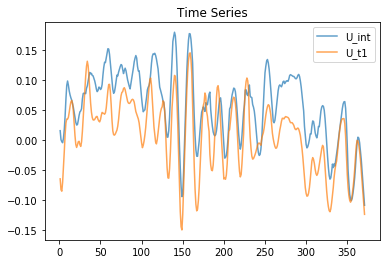

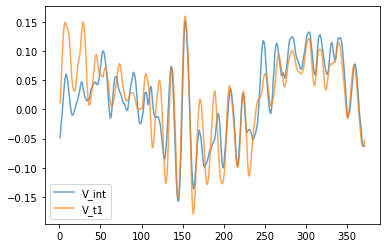

In [10]:
# compare time series of interpolated data to data at last position
plt.figure(1)
plt.plot(eddy['step'], U_k1, label='U_int', alpha=0.7)
lat = int((eddy['y1'][-1] - lowest_lat)/nav_res)
lon = int((eddy['x1'][-1] - lowest_lon)/nav_res)
print(lat, lon)
U_real = gridU_k1.variables['vozocrtx'][t0:t1+1, 0, lat, lon].copy()  # zonal velocities grid
V_real = gridV_k1.variables['vomecrty'][t0:t1+1, 0, lat, lon].copy()  # meridional velocities grid
otherTimes = np.arange(t0, t1+1, 1)
plt.plot(otherTimes,U_real, label='U_t1', alpha=0.7)
plt.legend()
plt.title('Time Series')

plt.figure(2)
plt.plot(eddy['step'], V_k1, label='V_int', alpha=0.7)
plt.plot(otherTimes,V_real, label='V_t1', alpha=0.7)
plt.plot()
plt.legend()
plt.show()

In [11]:
# perform fft on data at last position to compare with interpolated data
alpha=0.2

# Tapered cosine window
win = signal.tukey(len(otherTimes), alpha)  # 20% of points

hvel_real = np.array(U_real) + 1j*np.array(V_real)
fc_real = np.fft.fft(hvel_real*win)  # k1 Fourier coefficients (FCs) w/ window
amp_real = np.abs(fc_real)**2        # amplitude of k1 FCs

fq_real = np.fft.fftfreq(otherTimes.shape[-1],dt)    # frequencies corresponding to each FC (cycles/h)
fq_real_norm = fq_real*2*np.pi/fCor/3600             # normalized to coriolis frequency

# rearrange data for plotting
amp_real = np.fft.fftshift(amp_real)
fq_real_norm = np.fft.fftshift(fq_real_norm)

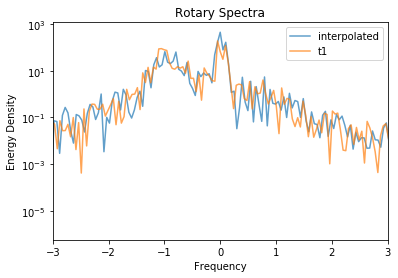

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [21]:
# compare rotary spectrum of interpolated data to spectrum of data at first position
plt.figure()
plt.plot(fq_k1_norm, amp_k1, label='interpolated', alpha=0.7)
plt.plot(fq_real_norm, amp_real, label='t1', alpha=0.7)
plt.xlim(-3,3)
#plt.ylim(10**0)

# plot labels
plt.title('Rotary Spectra')
plt.xlabel('Frequency')
plt.ylabel('Energy Density')
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
# import file
fpath_temp = '/gscratch/jisao/mclaret/GL64/Juin_Novembre/'
gridT_k1 = netcdf.netcdf_file(fpath_temp + 'GLazur64-T20_y2009m06_m11_gridT_k1.nc','r')

# keep variables
lat = gridT_k1.variables['nav_lat'][:][:].copy()
lon = gridT_k1.variables['nav_lon'][:][:].copy()
land = gridT_k1.variables['votemper'][0][0][:][:].copy()
water = gridT_k1.variables['votemper'][0][0][:][:].copy()
gridT_k1.close()

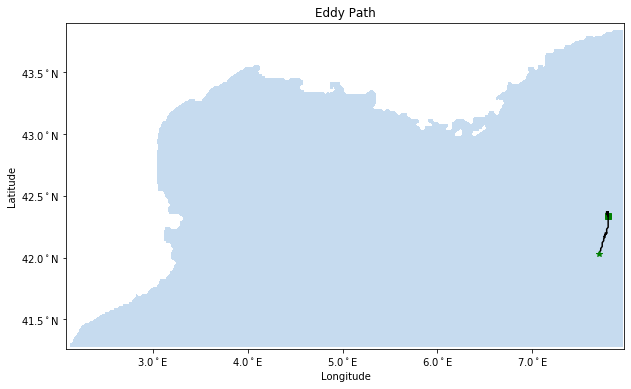

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
land = np.ma.masked_where(land == 0.0, land)
water = np.logical_not(land)

# plot map
plt.contourf(lon, lat, water,cmap='Blues')

# format lat/long labels
locs, labels = plt.xticks()
Elabels = [str(loc) + '$^\circ$E' for loc in locs]
plt.xticks(locs[1:-1], Elabels[1:-1])
locs, labels = plt.yticks()
Nlabels = [str(loc) + '$^\circ$N' for loc in locs]
plt.yticks(locs[1:-1], Nlabels[1:-1])

# plot eddy path
plt.plot(eddy['x1'][0], eddy['y1'][0], marker='s', color='g')    # initial position marked by square
plt.plot(eddy['x1'], eddy['y1'], color='k')                      # path
plt.plot(eddy['x1'][-1], eddy['y1'][-1], marker='*', color='g')  # final position marked by star

# figure labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Eddy Path')
plt.show()